In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from numpy import ndarray

SKINS_DIR = '../skins/'
FACES_DIR = '../faces/'

In [2]:
def read_face_file(file_name: str) -> ndarray:
    return mpimg.imread(os.path.join(FACES_DIR, file_name))

def read_skin_file(file_name: str) -> ndarray:
    return mpimg.imread(os.path.join(SKINS_DIR, file_name))

make `FACES_DIR` if not exists

In [3]:
if not os.path.isdir(FACES_DIR):
    os.mkdir(FACES_DIR)

## rename all files to zero-padded 5 digits

In [4]:
import os

skin_files = os.listdir(SKINS_DIR)
skin_files = sorted(skin_files)

for i, skin_file_name in enumerate(skin_files):
    new_file_name = "{:05d}".format(i + 1)
    
    file_path = os.path.join(SKINS_DIR, skin_file_name)
    
    _, extension = os.path.splitext(skin_file_name)
    
    new_file_path = os.path.join(SKINS_DIR, new_file_name + extension)
    
    os.rename(file_path, new_file_path)


## show mask and face

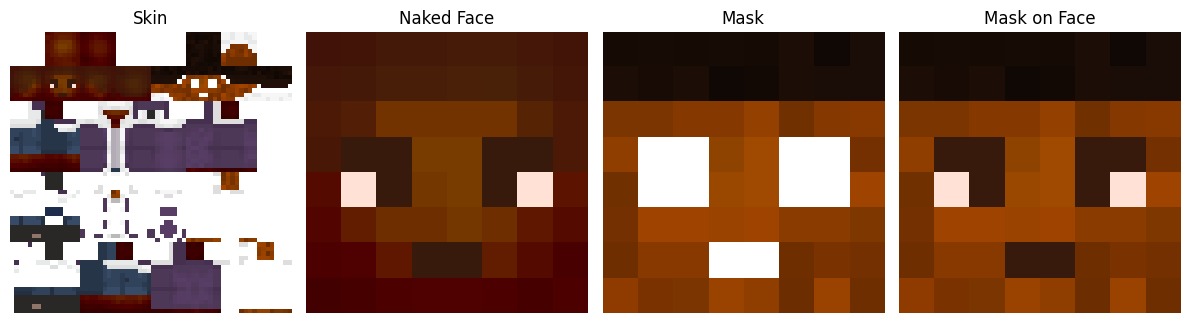

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4))

# source image: https://www.minecraftskins.com/skin/21856799/trial-boy/
skin = mpimg.imread("./trial-boy-21856799.png")

# skin image
axs[0].imshow(skin)
axs[0].set_title('Skin')
axs[0].axis('off')

# naked face
face = skin[8:16, 8:16]
axs[1].imshow(face)
axs[1].set_title('Naked Face')
axs[1].axis('off')

# mask
mask = skin[8:16, 40:48]
axs[2].imshow(mask)
axs[2].set_title('Mask')
axs[2].axis('off')

# mask on face
new_face = face.copy()
opacity = mask[:, :, 3]
non_zero_opacity_indices = np.where(opacity != 0)
new_face[non_zero_opacity_indices] = mask[non_zero_opacity_indices]
axs[3].imshow(new_face)
axs[3].set_title('Mask on Face')
axs[3].axis('off')

plt.tight_layout()
plt.show()

## put mask on face and replace with skin

In [4]:
skins_files = os.listdir(SKINS_DIR)

for skin_file in skins_files:
    skin = read_skin_file(skin_file)
    face = skin[8:16, 8:16]
    mask = skin[8:16, 40:48]

    non_zero_opacity_indices = np.where(mask[:, :, 3] != 0)
    face[non_zero_opacity_indices] = mask[non_zero_opacity_indices]
    face = face[:, :, :3]    # convert from RGBA to RGB
    mpimg.imsave(os.path.join(FACES_DIR, skin_file), face)

In [7]:
mpimg.imread('../faces/' + skin_file)

array([[[0.        , 0.        , 0.        , 1.        ],
        [0.4745098 , 0.7176471 , 0.84313726, 1.        ],
        [0.4745098 , 0.7176471 , 0.84313726, 1.        ],
        [0.10588235, 0.09803922, 0.08627451, 1.        ],
        [0.10588235, 0.09803922, 0.08627451, 1.        ],
        [0.10588235, 0.09803922, 0.08627451, 1.        ],
        [0.10588235, 0.09803922, 0.08627451, 1.        ],
        [0.10588235, 0.09803922, 0.08627451, 1.        ]],

       [[0.4745098 , 0.7176471 , 0.84313726, 1.        ],
        [0.4745098 , 0.7176471 , 0.84313726, 1.        ],
        [0.4745098 , 0.7176471 , 0.84313726, 1.        ],
        [0.10588235, 0.09803922, 0.08627451, 1.        ],
        [0.10588235, 0.09803922, 0.08627451, 1.        ],
        [0.99607843, 0.81960785, 0.627451  , 1.        ],
        [0.10588235, 0.09803922, 0.08627451, 1.        ],
        [0.10588235, 0.09803922, 0.08627451, 1.        ]],

       [[0.4745098 , 0.7176471 , 0.84313726, 1.        ],
        [0

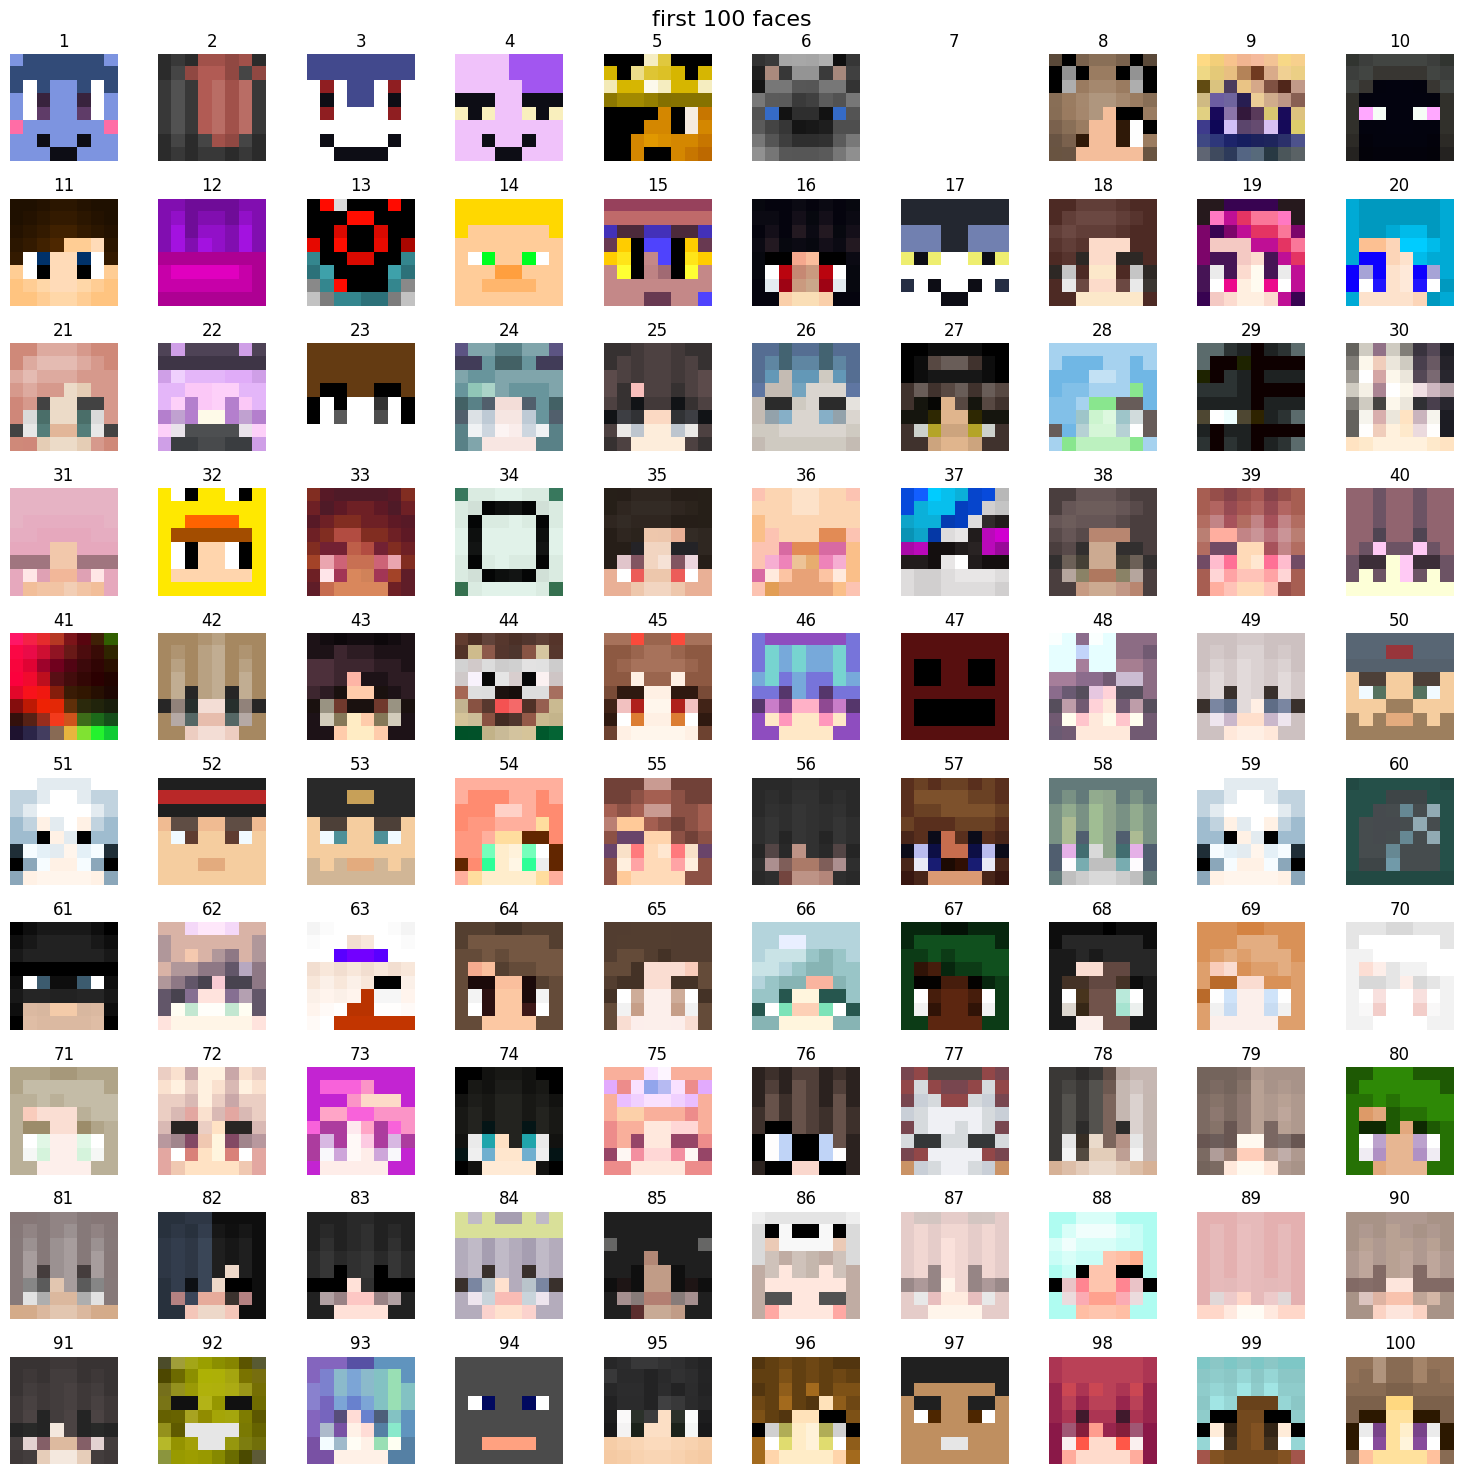

In [7]:
num_faces = 100
face_files = os.listdir(FACES_DIR)
face_files = sorted(face_files)

fig, axs = plt.subplots(num_faces // 10, 10, figsize=(15, 15))
fig.suptitle(f'first {num_faces} faces', fontsize=16)

for i, face_file in enumerate(face_files[:num_faces]):
    img = read_face_file(face_file)
    axs[i // 10, i % 10].imshow(img)
    axs[i // 10, i % 10].axis('off')
    axs[i // 10, i % 10].set_title(str(i + 1))

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

## feature selection to detect quality avatars

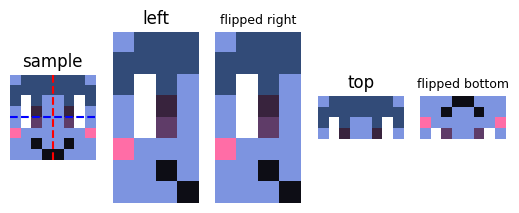

In [8]:
sample = read_face_file('00001.png')

left = sample[:, :4]
right = np.flip(sample[:, 4:], axis=1)
top = sample[:4]
bottom = np.flip(sample[4:], axis=0)

fig, axs = plt.subplots(1, 5)
axs[0].imshow(sample)
axs[0].set_title('sample')
axs[0].axis('off')
axs[0].axvline(x=3.5, color='red', linestyle='--')
axs[0].axhline(y=3.5, color='blue', linestyle='--')

axs[1].imshow(left)
axs[1].set_title('left')
axs[1].axis('off')

axs[2].imshow(right)
axs[2].set_title('flipped right', fontsize=9)
axs[2].axis('off')

axs[3].imshow(top)
axs[3].set_title('top')
axs[3].axis('off')

axs[4].imshow(bottom)
axs[4].set_title('flipped bottom', fontsize=9)
axs[4].axis('off')

plt.show()

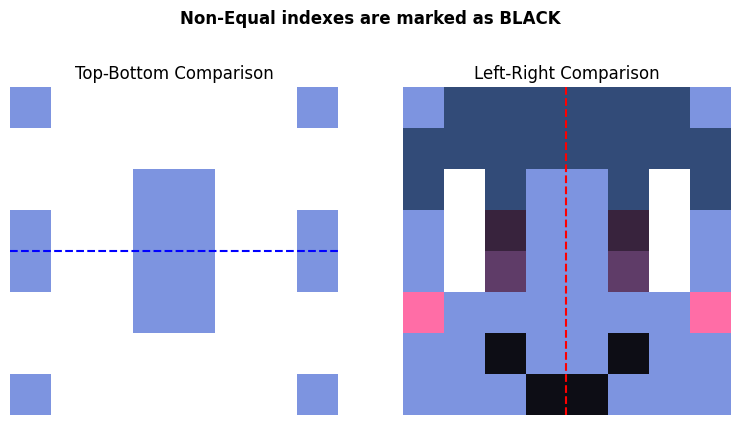

In [9]:
equal_pixels_tb = np.all(top == bottom, axis=2)
tb_compare = np.zeros_like(sample)
tb_compare[:4] = np.where(equal_pixels_tb[:, :, np.newaxis], top, 0)
tb_compare[4:] = np.where(equal_pixels_tb[:, :, np.newaxis], bottom, 0)
tb_compare[4:] = np.flip(tb_compare[4:], axis=0)


equal_pixels_lr = np.all(left == right, axis=2)
lr_compare = np.zeros_like(sample)
lr_compare[:, :4] = np.where(equal_pixels_lr[:, :, np.newaxis], left, 0)
lr_compare[:, 4:] = np.where(equal_pixels_lr[:, :, np.newaxis], right, 0)
lr_compare[:, 4:] = np.flip(lr_compare[:, 4:], axis=1)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Non-Equal indexes are marked as BLACK', fontsize=12, fontweight='bold', y=1.05)

axs[0].imshow(tb_compare)
axs[0].axhline(y=3.5, color='blue', linestyle='--')
axs[0].set_title('Top-Bottom Comparison')
axs[0].axis('off')

axs[1].imshow(lr_compare)
axs[1].axvline(x=3.5, color='red', linestyle='--')
axs[1].set_title('Left-Right Comparison')
axs[1].axis('off')

plt.tight_layout()
plt.show()

top-down and right-left symmetricity rate features

In [10]:
def calculate_tb_sym_rate(img: ndarray):
    top = img[:4]
    bottom = np.flip(img[4:], axis=0)
    tb_sym_count = (top == bottom).all(axis=2)
    return tb_sym_count.sum() / np.prod(tb_sym_count.shape)

def calculate_rl_sym_rate(img: ndarray):
    left = img[:, :4]
    right = np.flip(img[:, 4:], axis=1)
    rl_sym_count = (right == left).all(axis=2)
    return rl_sym_count.sum() / np.prod(rl_sym_count.shape)

color count feature

In [11]:
def calculate_num_colors(img: ndarray):
    pixels = img.reshape(-1, 3)
    return len(np.unique(pixels, axis=0))

make DataFrame

In [12]:
import pandas as pd

df = pd.DataFrame(columns=['file_name', 'rl_sym_rate', 'tb_sym_rate', 'num_colors'])

for face_file in face_files:
    tb_sym_rate = calculate_tb_sym_rate(img)

    rl_sym_rate = calculate_rl_sym_rate(img)

    num_colors = calculate_num_colors(img)

    df.loc[len(df)] = [face_file, rl_sym_rate, tb_sym_rate, num_colors]

df.sample(5)

ValueError: cannot reshape array of size 256 into shape (3)

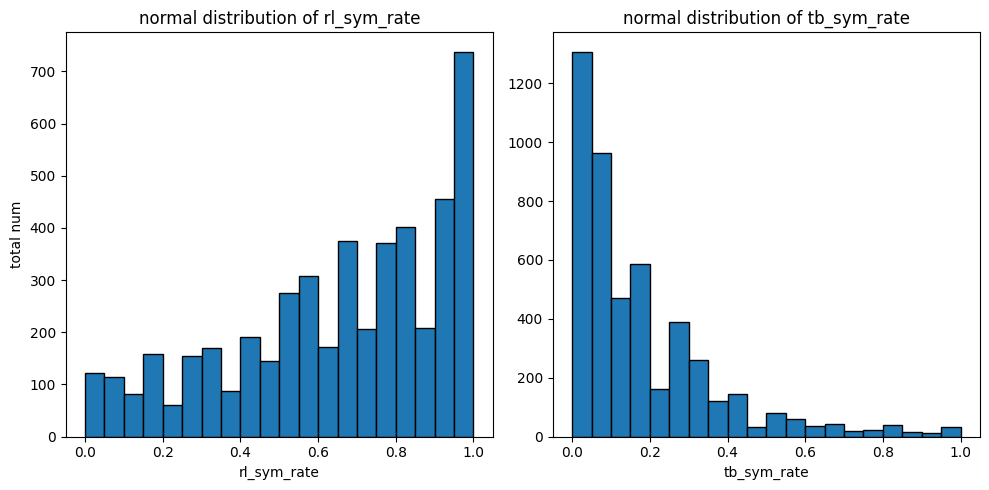

In [217]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# normal distribution of rl_sym_rate
axs[0].hist(df['rl_sym_rate'], bins=20, edgecolor='black')
axs[0].set_xlabel('rl_sym_rate')
axs[0].set_ylabel('total num')
axs[0].set_title('normal distribution of rl_sym_rate')

# normal distribution of tb_sym_rate
axs[1].hist(df['tb_sym_rate'], bins=20, edgecolor='black')
axs[1].set_xlabel('tb_sym_rate')
axs[1].set_title('normal distribution of tb_sym_rate')

plt.tight_layout()
plt.show()

add harmonic mean feature

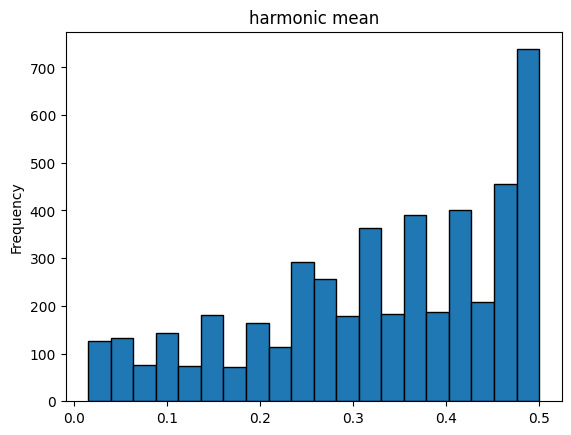

In [234]:
def harmonic_mean(feature1, feature2):
    return (feature1 * feature2) / (feature2 + feature2)

df['harmonic_mean'] = harmonic_mean(df['rl_sym_rate'], df['rl_sym_rate'])

df['harmonic_mean'].plot(kind='hist', bins=20, edgecolor='black')
plt.title('harmonic mean')
plt.show()